In [1]:
# Load libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

os.getcwd()

'C:\\Users\\David Olivero\\AnacondaProjects\\Loans-In-Colorado'

In [2]:
filename = 'data\\LIC_Model_Input.csv'

df = pd.read_csv(filename)

df.head().T

,0,1,2,3,4
ApprovalFY,2006,1997,1997,2005,1997
Term,264,60,120,35,60
NoEmp,2.19722,0.693147,1.38629,1.09861,0.693147
NewBiz,0,0,0,0,0
RevLineCr,0,0,0,0,0
LowDoc,0,1,0,0,1
DisbursementGross,1.5242e+06,90000,59000,50000,21200
MIS_Status,P I F,P I F,P I F,CHGOFF,P I F
County_Name,Mesa,Mesa,Mesa,Mesa,Mesa
TotalLoansInCounty,445,445,445,445,445


This time, instead of dropping the Industry column, I'd like to one-hot encode it. 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19298 entries, 0 to 19297
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ApprovalFY          19298 non-null  int64  
 1   Term                19298 non-null  int64  
 2   NoEmp               19298 non-null  float64
 3   NewBiz              19298 non-null  float64
 4   RevLineCr           19183 non-null  float64
 5   LowDoc              19242 non-null  float64
 6   DisbursementGross   19298 non-null  float64
 7   MIS_Status          19293 non-null  object 
 8   County_Name         19298 non-null  object 
 9   TotalLoansInCounty  19298 non-null  int64  
 10  PIF_RateByCounty    19298 non-null  float64
 11  MedIncome           19298 non-null  int64  
 12  PopChange           19298 non-null  float64
 13  EmployedInCty       19298 non-null  int64  
 14  UnempInCty          19298 non-null  int64  
 15  UnempRateInCty      19298 non-null  float64
 16  Deat

The MIS_Status column are my labels, so I will encode them with 1's and 0's:

In [4]:
# Replace MIS_Status column with 0's and 1's. 1 corresponds to a loan default. 

df['MIS_Status'] = df.MIS_Status.replace(to_replace=['P I F', 'CHGOFF'], value=[1, 0])

In [5]:
# There appear to be several non-numeric values in the DeathsPer100k column turning it into an object. 
df.DeathsPer100k.describe()

count     18970
unique       59
top       823.4
freq       3635
Name: DeathsPer100k, dtype: object

In [6]:
# Python is treating this column like string objects:
df.DeathsPer100k.value_counts().tail()

1372.6                 4
616.2                  2
537.9 (Unreliable)     1
1146.6                 1
1048.1 (Unreliable)    1
Name: DeathsPer100k, dtype: int64

In [7]:
# The object assignments comes from all the (Unreliable) numbers, so we will force these into numbers:

df['DeathsPer100k'] = pd.to_numeric(df['DeathsPer100k'], errors='coerce')

In [8]:
# There are still several rows with null values for this metric, so I will replace with the mean value of DeathsPer100k:

df['DeathsPer100k'].fillna((df['DeathsPer100k'].mean()), inplace=True)

In [9]:
df.DeathsPer100k.describe()

count    19298.000000
mean       625.524481
std        194.370452
min        160.800000
25%        551.900000
50%        565.800000
75%        823.400000
max       1372.600000
Name: DeathsPer100k, dtype: float64

In [10]:
# To review, a little over 17% of the loans in this dataset are defaulted, as seen below. 
df.MIS_Status.value_counts([0])

1.0    0.825429
0.0    0.174571
Name: MIS_Status, dtype: float64

In [11]:
# We can see we still have some probable nan's in the RevLineCr and PayDelay features:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19298 entries, 0 to 19297
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ApprovalFY          19298 non-null  int64  
 1   Term                19298 non-null  int64  
 2   NoEmp               19298 non-null  float64
 3   NewBiz              19298 non-null  float64
 4   RevLineCr           19183 non-null  float64
 5   LowDoc              19242 non-null  float64
 6   DisbursementGross   19298 non-null  float64
 7   MIS_Status          19293 non-null  float64
 8   County_Name         19298 non-null  object 
 9   TotalLoansInCounty  19298 non-null  int64  
 10  PIF_RateByCounty    19298 non-null  float64
 11  MedIncome           19298 non-null  int64  
 12  PopChange           19298 non-null  float64
 13  EmployedInCty       19298 non-null  int64  
 14  UnempInCty          19298 non-null  int64  
 15  UnempRateInCty      19298 non-null  float64
 16  Deat

In [12]:
# here we will fill the few nans in thie RevLineCr and PayDelay features with average values, to preserve dataset size.

df['RevLineCr'].fillna((df['RevLineCr'].mean()), inplace=True)
df['PayDelay'].fillna((df['PayDelay'].mean()), inplace=True)

In [13]:
df.shape

(19298, 19)

In [14]:
# We drop remaining rows with one or more nan fields and lose about 50 rows altogether. 

df = df.dropna()
df.shape

(19237, 19)

In this first iteration, we'll get dummies for the Industry column, and drop the County_Name column (for now). 

In [15]:
# Drop County Name column

df = df.drop(columns=['County_Name'])

Before running supervised learning models, we first run a KMeans unsupervised clustering algorithm on the dataset. This will hoepfully shed some light on whether or not there are any useful patterns in the dataset at very high dimensions. First I need to remove the Industry column so that there are no categorical variables being looked at. Looking at the Elbow plot below, one could argue that the "knee" in the curve is at n = 3. My interpretation is that there are three knees: n = 2, n = 3 and n = 5. Hence I'll pick n = 5 for the final clustering algorithm.  

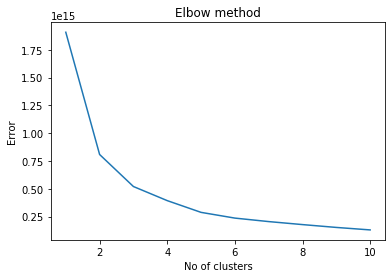

In [16]:
df1 = df.drop(columns=['Industry'])

from sklearn.cluster import KMeans

Error =[]
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i).fit(df1)
    kmeans.fit(df1)
    Error.append(kmeans.inertia_)
import matplotlib.pyplot as plt
plt.plot(range(1, 11), Error)
plt.title('Elbow method')
plt.xlabel('No of clusters')
plt.ylabel('Error')
plt.show()

In [17]:
# Create an array of cluster values for each row in the dataset
# Even though this is done on df1, we can apply results directly to df. 

kmeans3 = KMeans(n_clusters=5)
y_kmeans3 = kmeans3.fit_predict(df1)

Text(0.5, 0, 'PayDelay (days)')

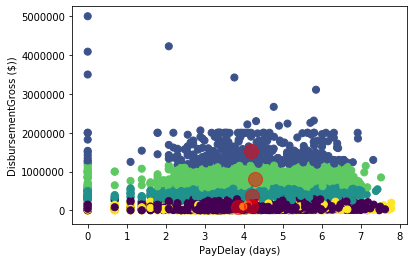

In [18]:
# Scatterplot of PayDelay vs. DirbursementGross gives us a glimpse into the clusters.
# Here the scatterplot is color-coded by cluster number. 

plt.scatter(df.PayDelay, df.DisbursementGross, c=y_kmeans3, s=50, cmap='viridis')

centers = kmeans3.cluster_centers_
plt.scatter(centers[:, 16], centers[:, 6], c='red', s=200, alpha=0.5);
plt.ylabel('DisbursementGross ($))')
plt.xlabel('PayDelay (days)')


In [19]:
# We add the clusters to df, and verify they're there.

df['Cluster'] = y_kmeans3.astype(str)

df.head().T

,0,1,2,3,4
ApprovalFY,2006,1997,1997,2005,1997
Term,264,60,120,35,60
NoEmp,2.19722,0.693147,1.38629,1.09861,0.693147
NewBiz,0,0,0,0,0
RevLineCr,0,0,0,0,0
LowDoc,0,1,0,0,1
DisbursementGross,1.5242e+06,90000,59000,50000,21200
MIS_Status,1,1,1,0,1
TotalLoansInCounty,445,445,445,445,445
PIF_RateByCounty,0.876404,0.876404,0.876404,0.876404,0.876404


In [20]:
df.groupby(by=['Cluster'])['MIS_Status'].value_counts([0])

Cluster  MIS_Status
0        1.0           0.859766
         0.0           0.140234
1        1.0           0.931122
         0.0           0.068878
2        1.0           0.896534
         0.0           0.103466
3        1.0           0.904513
         0.0           0.095487
4        1.0           0.760661
         0.0           0.239339
Name: MIS_Status, dtype: float64

In [21]:
from sklearn.decomposition import PCA
    
pca = PCA()

In [22]:
pca.fit(df1)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

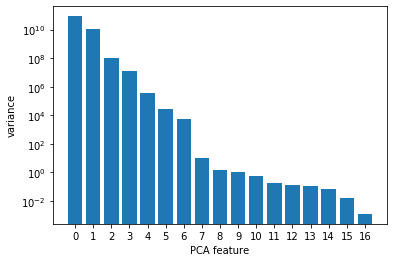

In [23]:
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.yscale('log')
plt.xticks(features)
plt.show()

In [24]:
df = pd.get_dummies(df, drop_first=True)

df.describe().T

,count,mean,std,min,25%,50%,75%,max
ApprovalFY,19237.0,2001.545979,5.515779,1990.000000,1997.000000,2003.000000,2006.000000,2.014000e+03
Term,19237.0,124.382024,84.809523,0.000000,66.000000,84.000000,180.000000,3.720000e+02
NoEmp,19237.0,1.540218,1.319098,-6.907755,0.693147,1.386294,2.397895,8.486115e+00
NewBiz,19237.0,0.229402,0.420459,0.000000,0.000000,0.000000,0.000000,1.000000e+00
RevLineCr,19237.0,0.244121,0.428288,0.000000,0.000000,0.000000,0.000000,1.000000e+00
LowDoc,19237.0,0.120653,0.325732,0.000000,0.000000,0.000000,0.000000,1.000000e+00
DisbursementGross,19237.0,235977.974580,296525.979335,4800.000000,51980.000000,126000.000000,300000.000000,5.000000e+06
MIS_Status,19237.0,0.825960,0.379153,0.000000,1.000000,1.000000,1.000000,1.000000e+00
TotalLoansInCounty,19237.0,1677.550606,1159.578062,1.000000,506.000000,1556.000000,2046.000000,3.647000e+03
PIF_RateByCounty,19237.0,0.825914,0.049815,0.500000,0.797654,0.821979,0.846377,1.000000e+00


In [25]:
df.shape

(19237, 41)

We'll start with a Dummy Classifier model based on stratification, then move to a simple Logistic regression model:

In [26]:
# Load libraries:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, roc_auc_score


In [27]:
# Split the dataset into features and target:
y = df['MIS_Status']
X = df.drop(columns='MIS_Status')

In [28]:
# Standardizr the various features in the dataset, since different variables have different ranges:

scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [29]:
# Create training and test data

X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.2, random_state=42)

In [30]:
# Dummy model based on stratificaation:

dummy = DummyClassifier(strategy='stratified', random_state=13)

dummy.fit(X_train, y_train)

dummy.score(X_test, y_test)

0.7154365904365905

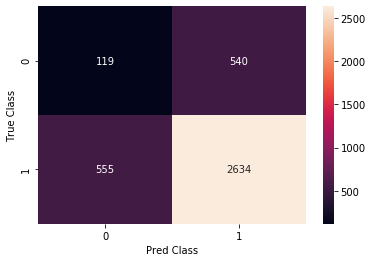

In [31]:
y_pred_strat = dummy.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_strat).ravel()
(tn, fp, fn, tp)

stratmatrix = pd.DataFrame(confusion_matrix(y_test, y_pred_strat))

sns.heatmap(stratmatrix, annot=True, fmt='d')
plt.ylabel('True Class'), plt.xlabel('Pred Class')
plt.show()

In [32]:
# We create target probabilities for the predicted values of y:

target_probabilities = dummy.predict_proba(X_test)[:,1]

FP_rate, TP_rate, threshold = roc_curve(y_test, target_probabilities)

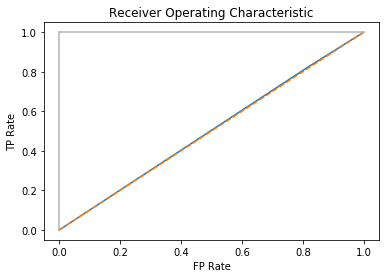

In [33]:
# Plot ROC Curve
plt.title('Receiver Operating Characteristic')
plt.plot(FP_rate, TP_rate)
plt.plot([0,1], ls='--')
plt.plot([0,0],[1,0], c='.7'), plt.plot([1,1], c='.7')
plt.ylabel('TP Rate')
plt.xlabel('FP Rate')
plt.show()

In [34]:
# Dummy model based on assuming that ALL loan are good loans! I.e., a constant value of 1:

dummy = DummyClassifier(strategy='constant', constant = 1)

dummy.fit(X_train, y_train)

dummy.score(X_test, y_test)

0.8287422037422038

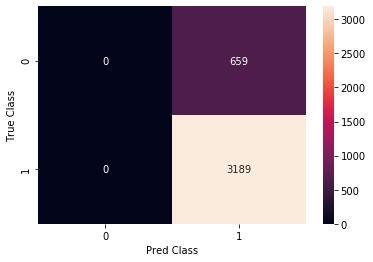

In [35]:
y_pred_constant = dummy.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_constant).ravel()
(tn, fp, fn, tp)

constmatrix = pd.DataFrame(confusion_matrix(y_test, y_pred_constant))

sns.heatmap(constmatrix, annot=True, fmt='d')
plt.ylabel('True Class'), plt.xlabel('Pred Class')
plt.show()

In [36]:
# We create target probabilities for the predicted values of y:

target_probabilities = dummy.predict_proba(X_test)[:,1]

FP_rate, TP_rate, threshold = roc_curve(y_test, target_probabilities)

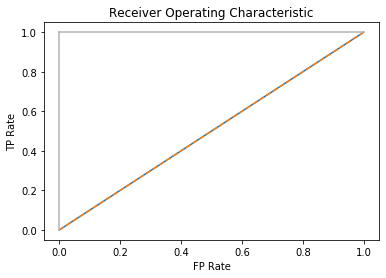

In [37]:
# Plot ROC Curve
plt.title('Receiver Operating Characteristic')
plt.plot(FP_rate, TP_rate)
plt.plot([0,1], ls='--')
plt.plot([0,0],[1,0], c='.7'), plt.plot([1,1], c='.7')
plt.ylabel('TP Rate')
plt.xlabel('FP Rate')
plt.show()

#### Logistic Regression ####

While the accuracy values of the dummy models were not that bad (the data are skewed towards loans being good, after all);  
Now we will explore Logistic Regression:

In [38]:
# Create a simple logistic regression model object and fit the training data

logit = LogisticRegression()

model = logit.fit(X_train, y_train)

In [39]:
# Accuracy score

model.score(X_test, y_test)

0.8840956340956341

In [40]:
# Make predictions for the test data set:
y_pred = model.predict(X_test)

In [41]:
# Generate a confusion matrix
matrix = pd.DataFrame(confusion_matrix(y_test, y_pred))

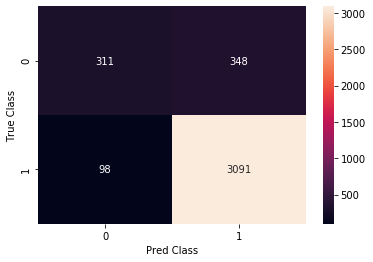

In [42]:
sns.heatmap(matrix, annot=True, fmt='d')
plt.ylabel('True Class'), plt.xlabel('Pred Class')
plt.show()

In [43]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
(tn, fp, fn, tp)

(311, 348, 98, 3091)

In [44]:
# F1 score is pretty good, but AUC is only 72% or so:

print(f1_score(y_test, y_pred), roc_auc_score(y_test, y_pred))

0.9327097163548582 0.7205982629020187


In [45]:
# We again create target probabilities for the predicted values of y:

target_probabilities = logit.predict_proba(X_test)[:,1]

FP_rate, TP_rate, threshold = roc_curve(y_test, target_probabilities)

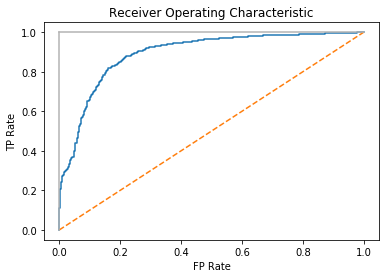

In [46]:
# Plot ROC Curve
plt.title('Receiver Operating Characteristic')
plt.plot(FP_rate, TP_rate)
plt.plot([0,1], ls='--')
plt.plot([0,0],[1,0], c='.7'), plt.plot([1,1], c='.7')
plt.ylabel('TP Rate')
plt.xlabel('FP Rate')
plt.show()

#### Random Forest Classifier ####

Next we'll explore a Random Forest classifier model to see if it can do a better job than the logistic regression:


In [47]:
# Load Random Forest library
from sklearn.ensemble import RandomForestClassifier


In [48]:
# Explore different n_estimaors, but keep the default gini criterion:

n_estimators = [50, 100, 150]

for estimators in n_estimators:
    rf = RandomForestClassifier(n_estimators=estimators, random_state = 17, n_jobs=-1)
    rf.fit(X_train, y_train)
    print("Num of Estimators: ", estimators)
    print("Accuracy score (training): {0:.3f}".format(rf.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(rf.score(X_test, y_test)))
    print()

Num of Estimators:  50
Accuracy score (training): 1.000
Accuracy score (validation): 0.932

Num of Estimators:  100
Accuracy score (training): 1.000
Accuracy score (validation): 0.932

Num of Estimators:  150
Accuracy score (training): 1.000
Accuracy score (validation): 0.933



In [49]:
# Try the same thing with the entropy criterion:

n_estimators = [50, 100, 150]

for estimators in n_estimators:
    rf = RandomForestClassifier(n_estimators=estimators, random_state = 17, n_jobs=-1, criterion = 'entropy')
    rf.fit(X_train, y_train)
    print("Num of Estimators: ", estimators)
    print("Accuracy score (training): {0:.3f}".format(rf.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(rf.score(X_test, y_test)))
    print()

Num of Estimators:  50
Accuracy score (training): 1.000
Accuracy score (validation): 0.935

Num of Estimators:  100
Accuracy score (training): 1.000
Accuracy score (validation): 0.935

Num of Estimators:  150
Accuracy score (training): 1.000
Accuracy score (validation): 0.935



In [50]:
# Use the optimal parameters:

randomforest = RandomForestClassifier(criterion = 'entropy', n_estimators=100, random_state=17, n_jobs=-1)

rfmodel = randomforest.fit(X_train, y_train)

In [51]:
y_predrf = rfmodel.predict(X_test)

In [52]:
# F1 score is pretty good, but AUC is only 71% or so:

print(f1_score(y_test, y_predrf), roc_auc_score(y_test, y_predrf))

0.9612665232093451 0.8461212694814448


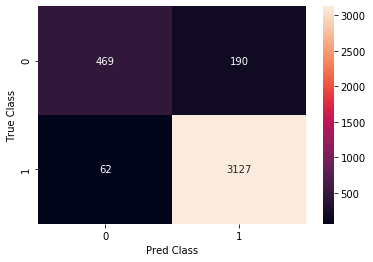

In [53]:
# Generate a confusion matrix
rfmatrix = pd.DataFrame(confusion_matrix(y_test, y_predrf))

sns.heatmap(rfmatrix, annot=True, fmt='d')
plt.ylabel('True Class'), plt.xlabel('Pred Class')
plt.show()

In [54]:
tn, fp, fn, tp = confusion_matrix(y_test, y_predrf).ravel()
(tn, fp, fn, tp)

(469, 190, 62, 3127)

In [55]:
# We again create target probabilities for the predicted values of y:

rf_target_probabilities = rfmodel.predict_proba(X_test)[:,1]

FP_rate, TP_rate, threshold = roc_curve(y_test, rf_target_probabilities)

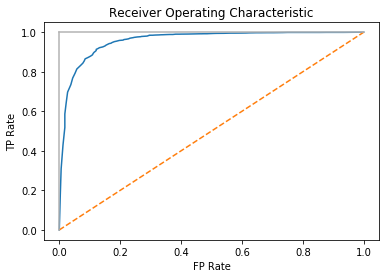

In [56]:
# Plot ROC Curve
plt.title('Receiver Operating Characteristic')
plt.plot(FP_rate, TP_rate)
plt.plot([0,1], ls='--')
plt.plot([0,0],[1,0], c='.7'), plt.plot([1,1], c='.7')
plt.ylabel('TP Rate')
plt.xlabel('FP Rate')
plt.show()

This model seems to have a signifcantly better ROC behavior than previous models. But, we don't know the relative significance, or importance, of the features in X_train and X_test. So, let's look at that next:

10


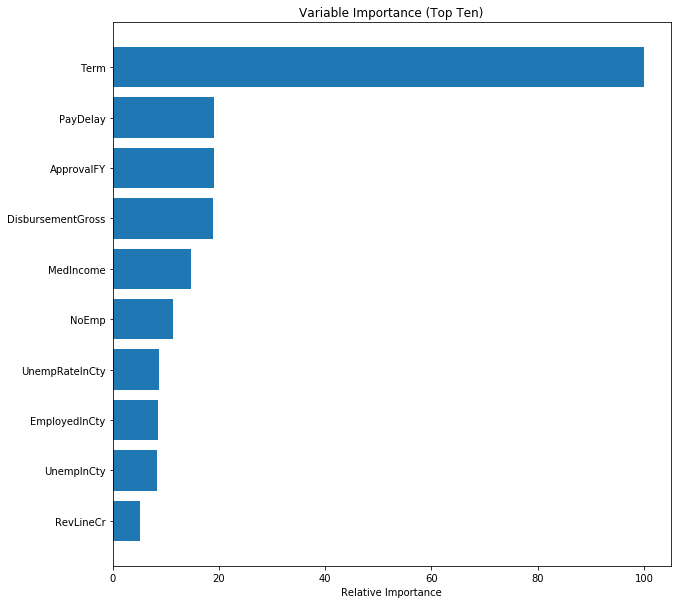

In [57]:
# obtain the feature importances from the random forest model:
feature_importance = rfmodel.feature_importances_

# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[-10:]

# Plot the relative importances on a horizontal barchart:


pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance (Top Ten)')
plt.show()

In [58]:
np.argsort(rfmodel.feature_importances_)[-10:]

array([ 4, 12, 11, 13,  2,  9,  6,  0, 15,  1], dtype=int64)

### Gradient Boosting ###
This was a first attempt at a random forest decision tree model. Next step will be exploration of Gradient Boost approaches (for a data set this small the computational expense will be negligible). 

In [59]:
from sklearn.ensemble import GradientBoostingClassifier

In [60]:

learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    gb = GradientBoostingClassifier(n_estimators=20, learning_rate = learning_rate, max_features=5, max_depth = 5, random_state = 0)
    gb.fit(X_train, y_train)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb.score(X_test, y_test)))
    print()

Learning rate:  0.05
Accuracy score (training): 0.877
Accuracy score (validation): 0.878

Learning rate:  0.1
Accuracy score (training): 0.920
Accuracy score (validation): 0.918

Learning rate:  0.25
Accuracy score (training): 0.929
Accuracy score (validation): 0.923

Learning rate:  0.5
Accuracy score (training): 0.944
Accuracy score (validation): 0.926

Learning rate:  0.75
Accuracy score (training): 0.948
Accuracy score (validation): 0.926

Learning rate:  1
Accuracy score (training): 0.951
Accuracy score (validation): 0.928



In [61]:
# Fit the best model: 

gb = GradientBoostingClassifier(n_estimators=20, learning_rate = 0.5, max_features=5, max_depth = 5, random_state = 0)
gb.fit(X_train, y_train)

y_predgb = gb.predict(X_test)


In [62]:
# F1 score is pretty good, but AUC is only 71% or so:

print(f1_score(y_test, y_predgb), roc_auc_score(y_test, y_predgb))

0.9562664194096739 0.8424646844164143


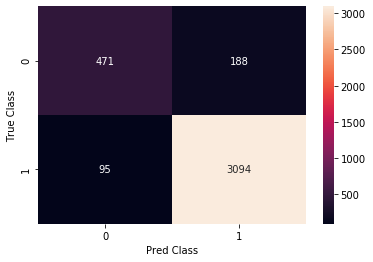

In [63]:
# Generate a confusion matrix
gbmatrix = pd.DataFrame(confusion_matrix(y_test, y_predgb))

sns.heatmap(gbmatrix, annot=True, fmt='d')
plt.ylabel('True Class'), plt.xlabel('Pred Class')
plt.show()

In [64]:
tn, fp, fn, tp = confusion_matrix(y_test, y_predgb).ravel()

In [65]:
(tn, fp, fn, tp)

(471, 188, 95, 3094)

In [66]:
# We again create target probabilities for the predicted values of y:

gb_target_probabilities = gb.predict_proba(X_test)[:,1]

FP_rate, TP_rate, threshold = roc_curve(y_test, gb_target_probabilities)

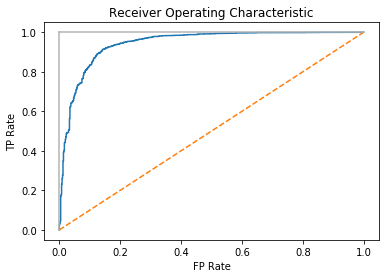

In [67]:
# Plot ROC Curve
plt.title('Receiver Operating Characteristic')
plt.plot(FP_rate, TP_rate)
plt.plot([0,1], ls='--')
plt.plot([0,0],[1,0], c='.7'), plt.plot([1,1], c='.7')
plt.ylabel('TP Rate')
plt.xlabel('FP Rate')
plt.show()

10


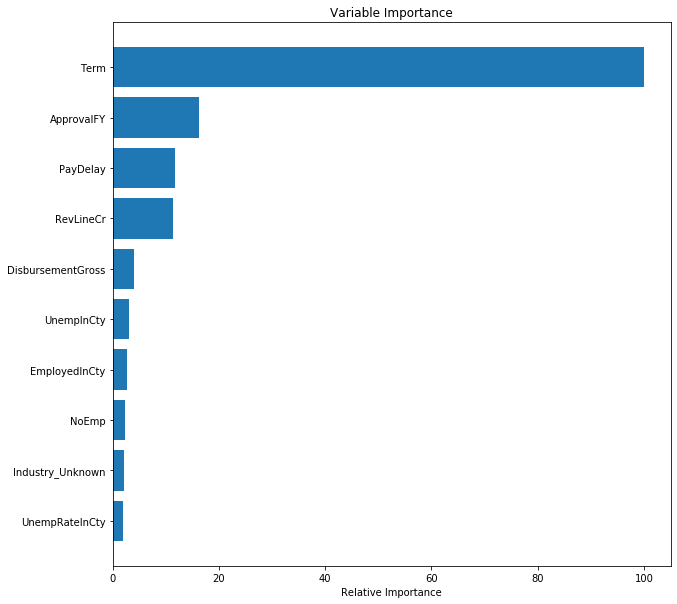

In [68]:
# obtain the feature importances from the random forest model:
feature_importance = gb.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[-10:]

# Plot the relative importances on a horizontal barchart:

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

### Examination of test set predictions### 
So far, the Gradient Boost model is doing the best at our stated goal: predicting loans with are destined for default. Out of 747 defaults in the test set, is accurately found 570 of them.  
Here we want to look at the differences in these two groups. 

In [69]:
y_test.head()

736      1.0
8711     0.0
5994     1.0
1958     1.0
11117    1.0
Name: MIS_Status, dtype: float64

In [70]:
yo = list(y_test.index)

yo = sorted(yo)

In [71]:
yo[0:5]

[0, 3, 6, 17, 19]

In [72]:
yo[-5:-1]

[19275, 19285, 19286, 19287]

In [74]:
df_test = df.loc[yo]

In [75]:
df_test.MIS_Status.value_counts()

1.0    3189
0.0     659
Name: MIS_Status, dtype: int64

In [76]:
y_t = pd.DataFrame(y_test)

In [77]:
y_t.head()

,MIS_Status
736,1.0
8711,0.0
5994,1.0
1958,1.0
11117,1.0


In [78]:
y_bool = ((y_test-y_predgb) == 0)

In [79]:
y_bool.value_counts()

True     3565
False     283
Name: MIS_Status, dtype: int64

In [80]:
y_t['Pred'] = y_bool

In [81]:
y_t['ind'] = y_t.index

In [82]:
y_t.head(10)

,MIS_Status,Pred,ind
736,1.0,True,736
8711,0.0,False,8711
5994,1.0,True,5994
1958,1.0,True,1958
11117,1.0,True,11117
6157,1.0,True,6157
17906,1.0,True,17906
5134,0.0,False,5134
200,1.0,True,200
2303,1.0,True,2303


In [83]:
df['ind'] = df.index
testset = pd.merge(y_t, df, how='left', on ='ind')

In [84]:
testset.head(10).T

,0,1,2,3,4,5,6,7,8,9
MIS_Status_x,1,0,1,1,1,1,1,0,1,1
Pred,True,False,True,True,True,True,True,False,True,True
ind,736,8711,5994,1958,11117,6157,17906,5134,200,2303
ApprovalFY,1996,1997,2002,2008,1999,1994,1990,2008,1993,2009
Term,120,48,120,84,84,9,60,63,84,84
NoEmp,1.38629,4.09434,1.09861,1.09861,1.79176,4.52179,1.94591,3.61092,4.86753,0
NewBiz,1,0,1,0,0,0,0,0,0,0
RevLineCr,0,0,0,1,0,0,0,1,0,1
LowDoc,1,0,1,0,0,0,0,0,0,0
DisbursementGross,45000,416000,117000,116336,150000,400000,57000,110541,80000,82157


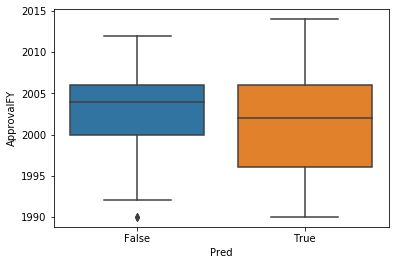

In [85]:
sns.boxplot(y='ApprovalFY', x='Pred', data=testset)

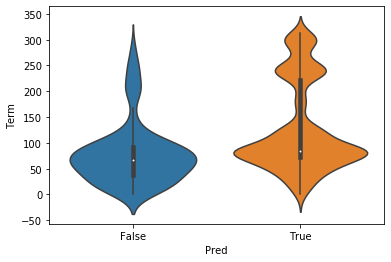

In [86]:
sns.violinplot(y='Term', x='Pred', data=testset)

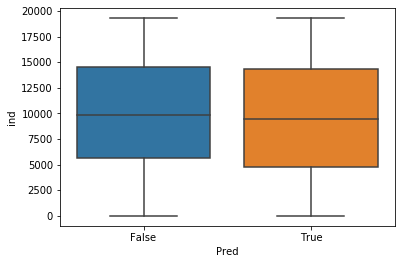

In [87]:
sns.boxplot(y='ind', x='Pred', data=testset)

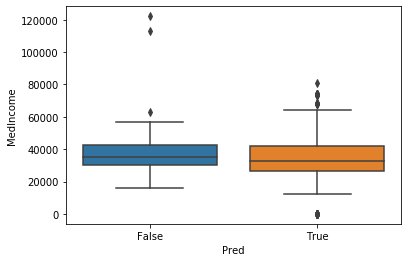

In [88]:
sns.boxplot(y='MedIncome', x='Pred', data=testset)

In [89]:
#Looking at the IQRs of the dataset grouped by accurate (True) predictions and inaccurate (False) predictions, 
# we see that inaccurate predictions tend towards shorter loan terms, shorter PayDelays, and generally larger counties
# as evidenced by Median Income, TotalLoansInCounty and UnempInCty features all being skewed higher. 

testset.groupby(by='Pred').quantile([0.25,0.75]).T

Pred                             False                        True   \
                                  0.25           0.75          0.25   
MIS_Status_x                  0.000000       1.000000      1.000000   
ind                        5650.000000   14549.500000   4797.000000   
ApprovalFY                 2000.000000    2006.000000   1996.000000   
Term                         37.000000      93.000000     72.000000   
NoEmp                         0.693147       2.302585      0.693147   
NewBiz                        0.000000       1.000000      0.000000   
RevLineCr                     0.000000       0.000000      0.000000   
LowDoc                        0.000000       0.000000      0.000000   
DisbursementGross         46024.500000  313100.000000  50299.000000   
MIS_Status_y                  0.000000       1.000000      1.000000   
TotalLoansInCounty          655.500000    2046.000000    506.000000   
PIF_RateByCounty              0.797654       0.839232      0.797654   
MedIncome                 29976.500000   42708.000000  26244.000000   
PopChange                     0.139801       0.293547      0.139801   
EmployedInCty            102288.000000  282153.000000  85472.000000   
UnempInCty                 4746.500000   14216.500000   4107.000000   
UnempRateInCty                3.900000       5.600000      3.800000   
DeathsPer100k               551.900000     660.212241    551.900000   
PayDelay                      3.332205       4.488573      3.433987   
Industry_Administrative       0.000000       0.000000      0.000000   
Industry_Agriculture          0.000000       0.000000      0.000000   
Industry_Arts                 0.000000       0.000000      0.000000   
Industry_Construction         0.000000       0.000000      0.000000   
Industry_Educational          0.000000       0.000000      0.000000   
Industry_Finance              0.000000       0.000000      0.000000   
Industry_Health               0.000000       0.000000      0.000000   
Industry_Information          0.000000       0.000000      0.000000   
Industry_Management           0.000000       0.000000      0.000000   
Industry_Manufacturing        0.000000       0.000000      0.000000   
Industry_Mining               0.000000       0.000000      0.000000   
Industry_Other                0.000000       0.000000      0.000000   
Industry_Professional         0.000000       0.000000      0.000000   
Industry_Public               0.000000       0.000000      0.000000   
Industry_Real                 0.000000       0.000000      0.000000   
Industry_Retail               0.000000       0.000000      0.000000   
Industry_Transportation       0.000000       0.000000      0.000000   
Industry_Unknown              0.000000       0.000000      0.000000   
Industry_Utilities            0.000000       0.000000      0.000000   
Industry_Wholesale            0.000000       0.000000      0.000000   
Cluster_1                     0.000000       0.000000      0.000000   
Cluster_2                     0.000000       0.000000      0.000000   
Cluster_3                     0.000000       0.000000      0.000000   
Cluster_4                     0.000000       1.000000      0.000000   

Pred                                    
                                  0.75  
MIS_Status_x                  1.000000  
ind                       14354.000000  
ApprovalFY                 2006.000000  
Term                        222.000000  
NoEmp                         2.302585  
NewBiz                        0.000000  
RevLineCr                     0.000000  
LowDoc                        0.000000  
DisbursementGross        299000.000000  
MIS_Status_y                  1.000000  
TotalLoansInCounty         2046.000000  
PIF_RateByCounty              0.846377  
MedIncome                 41754.000000  
PopChange                     0.276615  
EmployedInCty            281272.000000  
UnempInCty                13903.000000  
UnempRateInCty                5.700000  
DeathsPer100k            

### XGBoost Classifier ###
As a last exploration, we look at Extreme-Gradient Boosting. 

In [90]:
import xgboost as xgb

In [91]:
churn_dmatrix = xgb.DMatrix(data=X_train, label=y_train)
params={"objective":"binary:logistic","max_depth":6}
cv_results = xgb.cv(dtrain=churn_dmatrix, params=params, 
                  nfold=3, num_boost_round=15, 
                  metrics="auc", as_pandas=True, seed=123)


In [92]:
print(cv_results)

    train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0         0.954738       0.002240       0.947178      0.003292
1         0.960569       0.001232       0.952337      0.002085
2         0.964740       0.000809       0.954221      0.001199
3         0.968579       0.001722       0.956413      0.001684
4         0.973071       0.000682       0.961554      0.000673
5         0.976405       0.001742       0.963161      0.001443
6         0.978227       0.002153       0.964362      0.002296
7         0.980255       0.000794       0.964605      0.002401
8         0.982342       0.001015       0.966641      0.002266
9         0.984678       0.000969       0.968338      0.001488
10        0.986007       0.000620       0.969689      0.001547
11        0.987221       0.000242       0.970935      0.002286
12        0.987805       0.000321       0.971207      0.002618
13        0.988464       0.000441       0.971681      0.003147
14        0.989285       0.000204       0.972381      0

In [93]:
xgmodel = xgb.XGBClassifier(objective = 'binary:logistic',max_depth = 5, num_boost_round=15, as_pandas=True, seed=123)

In [94]:
xgmodel.fit(X_train, y_train)

[16:31:55] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { as_pandas, num_boost_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(as_pandas=True, base_score=0.5, booster='gbtree',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_boost_round=15, num_parallel_tree=1,
              objective='binary:logistic', random_state=123, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=123, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [95]:
y_predxg = xgmodel.predict(X_test)

In [96]:
# F1 score is pretty good, but AUC is only 71% or so:

print(f1_score(y_test, y_predxg), roc_auc_score(y_test, y_predxg))

0.9706616729088638 0.9049126097820134


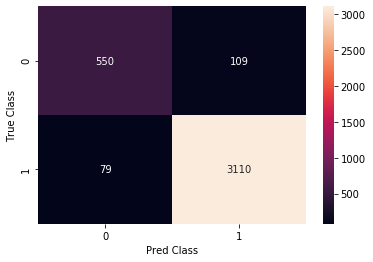

In [97]:
# Generate a confusion matrix
xgmatrix = pd.DataFrame(confusion_matrix(y_test, y_predxg))

sns.heatmap(xgmatrix, annot=True, fmt='d')
plt.ylabel('True Class'), plt.xlabel('Pred Class')
plt.show()

In [98]:
tn, fp, fn, tp = confusion_matrix(y_test, y_predxg).ravel()

In [99]:
(tn, fp, fn, tp)

(550, 109, 79, 3110)

In [100]:
# We again create target probabilities for the predicted values of y:

xg_target_probabilities = xgmodel.predict_proba(X_test)[:,1]

FP_rate, TP_rate, threshold = roc_curve(y_test, xg_target_probabilities)

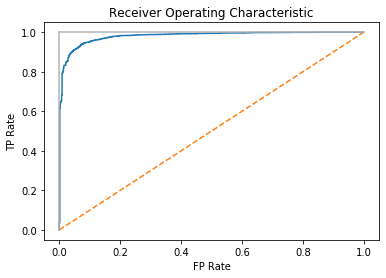

In [101]:
# Plot ROC Curve
plt.title('Receiver Operating Characteristic')
plt.plot(FP_rate, TP_rate)
plt.plot([0,1], ls='--')
plt.plot([0,0],[1,0], c='.7'), plt.plot([1,1], c='.7')
plt.ylabel('TP Rate')
plt.xlabel('FP Rate')
plt.show()

22


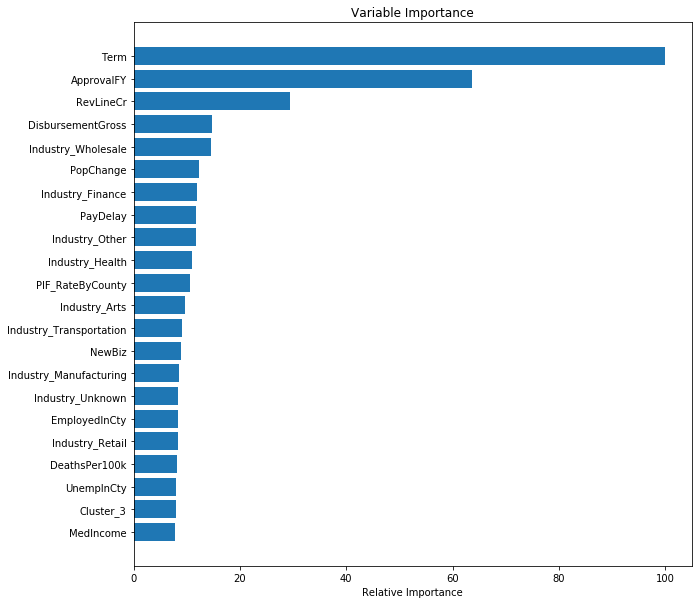

In [102]:
# obtain the feature importances from the random forest model:
feature_importance = xgmodel.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[-22:]


# Plot the relative importances on a horizontal barchart:

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

So, the winner is, XGBoost! This machine learning algorithm has done the best job at monimizing both false positive and false negatives in the holdout test set. 

## Branko's Idea: Train on old, test on new ##

I can't take credit for this idea, but Branko had an excellent point: If this model was actually used in real life, a lending institution would use it to predict FUTURE loan performance based on PAST behavior. This fundamentally changes the makeup of the training and test sets. We will recreate these two sets based on a time threshold; everythign before the threshold will be training data, everything after it will be test data. To keep the test set a reasonable size, we'll use the year 2010 as the threshold.  
  
  Another crucial point: We also lose one of our key predictor variables: PayDelay. Since we are talking about predicting loans in the future, we can have no way of knowing what the PayDelay value is for those loans. So that will have to be eliminated from the dataset for this analysis. 

In [103]:
# Split the dataset into features and target. Also remove the PayDelay feature:

y = df['MIS_Status']
X = df.drop(columns=['MIS_Status', 'PayDelay'])

In [104]:
# Standardize the various features in the dataset, since different variables have different ranges:

new = (df['ApprovalFY'] >= 2010 )
old = (df['ApprovalFY'] < 2010)

new.value_counts()
old.value_counts()

True     18354
False      883
Name: ApprovalFY, dtype: int64

In [105]:
# Standardize the various features in the dataset, since different variables have different ranges:

scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [106]:
X_test = X_std[new]
y_test = y[new]

In [107]:
X_train = X_std[old]
y_train = y[old]

In [108]:
churn_dmatrix = xgb.DMatrix(data=X_train, label=y_train)
params={"objective":"binary:logistic","max_depth":6}
cv_results = xgb.cv(dtrain=churn_dmatrix, params=params, 
                  nfold=3, num_boost_round=15, 
                  metrics="auc", as_pandas=True, seed=123)


In [109]:
print(cv_results)

    train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0         0.957473       0.002894       0.951514      0.001033
1         0.964072       0.001691       0.956107      0.002026
2         0.967416       0.003139       0.958423      0.001350
3         0.970590       0.000870       0.960955      0.001846
4         0.972978       0.001666       0.962331      0.002687
5         0.974333       0.001558       0.964232      0.002360
6         0.977970       0.001597       0.967149      0.001162
7         0.979799       0.001580       0.969058      0.001447
8         0.982152       0.000587       0.969575      0.001451
9         0.983686       0.000332       0.970421      0.001716
10        0.984993       0.000242       0.971390      0.001670
11        0.986064       0.000354       0.972299      0.002009
12        0.987106       0.000622       0.973198      0.001657
13        0.987933       0.000778       0.973874      0.001543
14        0.988465       0.000780       0.973875      0

In [110]:
xgmodel = xgb.XGBClassifier(objective = 'binary:logistic',max_depth = 6, num_boost_round=15, as_pandas=True, seed=123)

In [111]:
xgmodel.fit(X_train, y_train)

[16:38:50] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { as_pandas, num_boost_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(as_pandas=True, base_score=0.5, booster='gbtree',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_boost_round=15, num_parallel_tree=1,
              objective='binary:logistic', random_state=123, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=123, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [112]:
y_predxg2 = xgmodel.predict(X_test)

In [113]:
# F1 score is pretty good, and AUC achieved is 88.4%

print(f1_score(y_test, y_predxg2), roc_auc_score(y_test, y_predxg2))

0.9671302149178256 0.8843400757365845


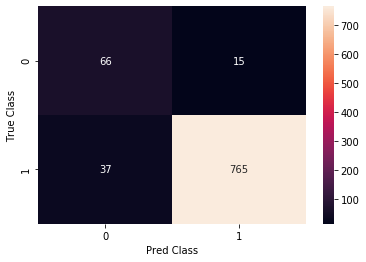

In [114]:
# Generate a confusion matrix
xgmatrix = pd.DataFrame(confusion_matrix(y_test, y_predxg2))

sns.heatmap(xgmatrix, annot=True, fmt='d')
plt.ylabel('True Class'), plt.xlabel('Pred Class')
plt.show()

In [115]:
tn, fp, fn, tp = confusion_matrix(y_test, y_predxg2).ravel()
(tn, fp, fn, tp)

(66, 15, 37, 765)

22


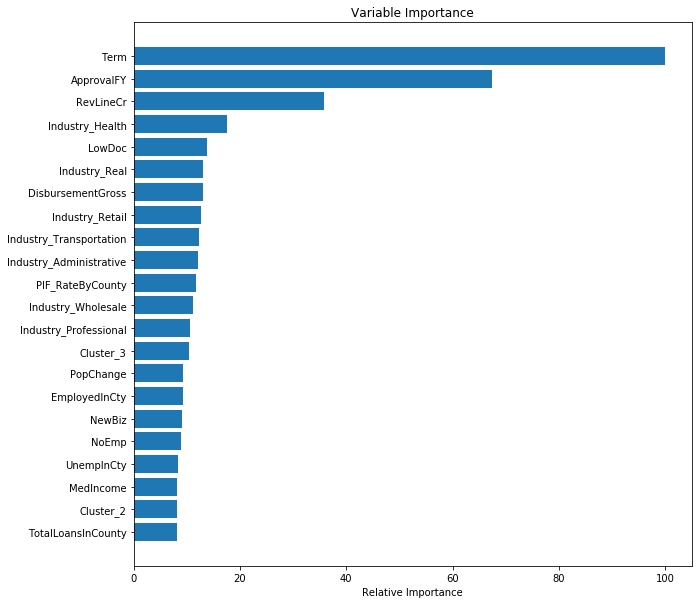

In [116]:
# obtain the feature importances from the random forest model:
feature_importance = xgmodel.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[-22:]

# Plot the relative importances on a horizontal barchart:

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()